# TP2 - Market Basket Analysis 
INF8111 - Fouille de données, Automne 2021
### Membres de l'équipe
    - Verdet Alexandre (2164847) 1


## Date et directives de remise
Vous remettrez ce fichier nommé TP2\_NomDuMembre1\_NomDuMembre2\_NomDuMembre3.ipynb dans la boîte de remise sur moodle. 

**Date limite: October 31 at 23:55**.


## Market Basket Analysis

Le *Market Basket Analysis* (MBA) est une technique d'analyse de la fouille de données qui permet de découvrir les associations entre les produits ou leur regroupement. En explorant des motifs intéressants à partir d'une vaste collection de données, le MBA vise à comprendre / révéler les comportements d'achat des clients en se basant sur la théorie selon laquelle si vous avez acheté un certain ensemble de produits, vous êtes plus (ou moins) susceptible d'acheter un autre groupe de produits. En d'autres termes, le MBA permet aux détaillants d'identifier la relation entre les articles que les clients achètent, révélant des tendances d'articles souvent achetés ensemble.

Une approche largement utilisée pour explorer ces motifs consiste à construire *** des règles d'association *** telles que
- **si** acheté *ITEM_1* **alors** achètera *ITEM_2* avec **confiance** *X*.

Ces associations n'ont pas à être des règles individuelles. Ils peuvent impliquer de nombreux éléments. Par exemple, une personne dans un supermarché peut ajouter des œufs dans son panier, puis le MBA peut suggérer qu'elle achètera également du pain et/ou de la farine:

+ **si**  acheté *OEUFS* **alors** achètera [*PAIN* avec confiance *0,2*; *FARINE* avec confiance 0,05].

Cependant, si la personne décide maintenant d'ajouter de la farine à son panier, la nouvelle règle d'association pourrait être comme ci-dessous, suggérant des ingrédients pour faire un gâteau.

+ **si** acheté [*OEUFS, FARINE*] **alors** achètera [*SUCRE* avec confiance 0,45; LEVURE avec confiance 0,12; *PAIN* avec confiance *0,03*].

Il existe de nombreux scénarios réels où le MBA joue un rôle central dans l'analyse des données, comme les transactions de supermarché, les commandes en ligne ou l'historique des cartes de crédit. Les spécialistes du marketing peuvent utiliser ces règles d'association pour organiser les produits corrélés plus près les uns des autres sur les étagères des magasins ou faire des suggestions en ligne afin que les clients achètent plus d'articles. Un MBA peut généralement aider les détaillants à répondre aux questions les suivantes:

- Quels articles sont souvent achetés ensemble ?
- Étant donné un panier, quels articles suggérer ?
- Comment placer les articles ensemble sur les étagères ?

### Objectif

Votre objectif dans ce TP est de développer un algorithme MBA pour révéler les motifs en créant des règles d'association dans un ensemble de données volumineux avec plus de trois millions de transactions de supermarché. Cependant, la collecte de règles d'association dans les grands ensembles de données est un problème très intensif en calcul, ce qui rend presque impossible leur exécution sans système distribué. Par conséquent, pour exécuter votre algorithme, vous aurez accès à un cluster de *cloud computing* distribué avec des centaines de cœurs.

À cette fin, un algorithme **MapReduce** sera implémenté avec le framework [Apache Spark](http://spark.apache.org), un système informatique distribué rapide. En résumé, Spark est un framework open source conçu avec une méthodologie *scale-out* qui en fait un outil très puissant pour les programmeurs ou les développeurs d'applications pour effectuer un volume massif de calculs et de traitement de données dans des environnements distribués. Spark fournit des API de haut niveau qui facilitent la création d'applications parallèles sans avoir à se soucier de la façon dont votre code et vos données sont parallélisés / distribués par le cluster informatique. Spark fait tout pour vous.

La mise en œuvre suivra l'algorithme d'analyse du panier de marché présenté par Jongwook Woo et Yuhang Xu (2012). L'image **workflow.pdf** illustre le flux de travail de l'algorithme et doit être utilisée pour consultation tout au long de ce TP. Les cases bleues sont celles où vous devez implémenter une méthode pour effectuer une fonction de mappage ou de réduction, et les cases grises représentent leur sortie attendue. **Toutes ces opérations sont expliquées en détail dans les sections suivantes.**

## 1. Configuration de Spark

Spark fonctionne sur les systèmes Windows et UNIX (par exemple, Linux, Mac OS). Il est facile d'exécuter Spark localement sur une seule machine - tout ce dont vous avez besoin est d'avoir Java installé sur votre système PATH, ou la variable d'environnement JAVA_HOME pointant vers une installation Java. Il est obligatoire que le **JDK v8** soit installé sur votre système, car Spark ne prend actuellement en charge que cette version. Si ce n'est pas le cas, accédez à [la page Web de Java](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) pour télécharger et installer une machine virtuelle Java. N'oubliez pas de définir la variable d'environnement JAVA_HOME pour utiliser JDK v8 si votre installation ne le fait pas automatiquement.

L'interface entre Python et Spark se fait via **PySpark**, qui peut être installé en exécutant `pip install pyspark` ou configuré en suivant la séquence ci-dessous:

1. D'abord, allez sur http://spark.apache.org/downloads
2. Sélectionnez la dernière version de Spark et le package pré-construit pour Apache Hadoop 2.7
3. Cliquez pour télécharger **spark-2.4.5-bin-hadoop2.7.tgz** et décompressez-le dans le dossier de votre choix.
4. Ensuite, exportez les variables suivantes pour lier PYSPARK (l'interface python de Spark) à votre distribution python dans votre fichier `~/.bash_profile`.

``
export SPARK_HOME=/chemin/ vers / spark-2.4.5-bin-hadoop2.7
export PYTHONPATH="$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$SPARK_HOME/python/lib/pyspark.zip:$ PYTHONPATH"
export PYSPARK_PYTHON=/chemin/vers/votre/python3
``

5. Exécutez `source ~./bash_profile` pour effectuer les modifications et redémarrer cette session de notebook jupyter.


In [2]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark

     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 198 kB 50.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=e9163e2b1b3ed6de86f59aa2e63c766e90be9eb96de3459827d81823a3be76f5
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


#### Testez votre Spark
À l'aide du code suivant, vous pouvez tester si Spark est installé correctement.

In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



### 1.1 Exemple de comptage de produits 

Pour tester votre installation et commencer à vous familiariser avec Spark, nous suivrons un exemple qui compte combien de fois les produits d'un toy dataset ont été achetés.

Le principal point d'entrée pour commencer la programmation avec Spark est [l'API RDD](https://spark.apache.org/docs/latest/rdd-programming-guide.html), une excellente abstraction Spark pour travailler avec MapReduce. RDD est une collection d'éléments partitionnés sur les nœuds du cluster qui peuvent fonctionner en parallèle. En d'autres termes, RDD est la façon dont Spark maintient vos données prêtes à exécuter une fonction (par exemple, une fonction Map ou une fonction reduce) en parallèle. **Ne vous inquiétez pas si cela semble toujours déroutant, il sera clair une fois que vous commencerez à l'implémenter**. Cependant, cela fait partie de ce TP d'étudier / consulter [Spark python API](https://spark.apache.org/docs/latest/api/python/) et d'apprendre à l'utiliser. Certaines fonctions utiles offertes par l'API RDD sont:

1. **map**: return a new RDD by applying a function to each element of this RDD.
2. **flatMap**: return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. **Should be used when each entry will yield more than one mapped element**
3. **reduce**: reduces the elements of this RDD using the specified commutative and associative binary operator.
4. **reduceByKey**: merge the values for each key using an associative and commutative reduce function
5. **groupByKey**: group the values for each key in the RDD into a single sequence
6. **collect**: return a list that contains all of the elements in this RDD. **Should not be used when working with a lot of data**
7. **sample**: return a sampled subset of this RDD
8. **count**: return the number of elements in this RDD.
9. **filter**: return a new RDD containing only the elements that satisfy a predicate.

In [5]:
from pyspark.sql import SparkSession

def map_to_product(row):
    """
    Map each transaction into a set of KEY-VALUE elements.
    The KEY is the word (product) itself and the VALUE is its number of apparitions.
    """
    products = row.transaction.split(';') # split products from the column transaction
    for p in products:
        yield (p, 1)

def reduce_product_by_key(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1+value2

# Initializates a object of SparkSession class, main entry point to Spark's funcionalites
spark = SparkSession.builder.getOrCreate()
        
# Read a toy dataset
toy = spark.read.csv('toy.csv', header=True)
#toy = spark.read.csv('gs://inf81111-bucket-tp2-12781749821/toy.csv', header=True)
print("Toy dataset")
toy.show()

# Obtain a RDD object to call a map function
toy_rdd = toy.rdd
print("Toy dataframe as a RDD object (list of Row objects):\n\t", toy_rdd.collect())

# Map function to identify all products
toy_rdd = toy_rdd.flatMap(map_to_product)
print("\nMapped products:\n\t", toy_rdd.collect())

# Reduce function to merge values of elements that share the same KEY
toy_rdd = toy_rdd.reduceByKey(reduce_product_by_key)
print("\nReduced (merged) products:\n\t", toy_rdd.collect())

print("\nVisualizing as a dataframe:")
toy_rdd.toDF(["product", "count_product"]).show()

Toy dataset
+--------+-----------+
|order_id|transaction|
+--------+-----------+
|       1|    a;b;c;f|
|       2|    d;b;a;e|
|       3|        c;b|
|       4|        b;c|
+--------+-----------+

Toy dataframe as a RDD object (list of Row objects):
	 [Row(order_id='1', transaction='a;b;c;f'), Row(order_id='2', transaction='d;b;a;e'), Row(order_id='3', transaction='c;b'), Row(order_id='4', transaction='b;c')]

Mapped products:
	 [('a', 1), ('b', 1), ('c', 1), ('f', 1), ('d', 1), ('b', 1), ('a', 1), ('e', 1), ('c', 1), ('b', 1), ('b', 1), ('c', 1)]

Reduced (merged) products:
	 [('a', 2), ('b', 4), ('c', 3), ('f', 1), ('d', 1), ('e', 1)]

Visualizing as a dataframe:
+-------+-------------+
|product|count_product|
+-------+-------------+
|      a|            2|
|      b|            4|
|      c|            3|
|      f|            1|
|      d|            1|
|      e|            1|
+-------+-------------+



### 1.2 Travailler avec Spark Dataframe

Dans l'exemple ci-dessus, nous avons brièvement utilisé une classe Dataframe de Spark, mais uniquement pour obtenir un objet RDD avec ``toy.rdd`` et pour aficher les données sous forme de tableau structuré avec le ``show ()`` une fonction. Cependant, [Dataframe](http://spark.apache.org/docs/latest/api/python/) est une partie cruciale de la version actuelle de Spark et est construit sur l'API RDD. Il s'agit d'une collection distribuée de lignes sous des colonnes nommées, identique à une table dans une base de données relationnelle. Le Dataframe de Spark fonctionne de la même manière que [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). En fait, nous pouvons exporter (obtenir) une Dataframe Spark vers (à partir de) ​​une Dataframe pandas avec la fonction ``toPandas()``  (``spark.createDataFrame``).

Une fonctionnalité centrale du Dataframe est de bénéficier du [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), un module qui permet des requêtes SQL sur des données structurées. Par exemple, le même « exemple de comptage de produits » aurait pu être implémenté comme une séquence d'opérations SQL sur les données:

In [6]:
import pyspark.sql.functions as f

# Creates a new column, products, with all products appering in each transaction
print('New column \'products\': exploding the transaction\'s products to a new row')
df_toy = toy.withColumn('products', f.explode(f.split(toy.transaction, ';')))
df_toy.show()

# Performs a select query and group rows by the product name, aggreagating by counting
print('Couting unique products:')
df_toy.select(df_toy.products)\
      .groupBy(df_toy.products)\
      .agg(f.count('products').alias('count_product'))\
      .sort('count_product', ascending=False)\
      .show()

New column 'products': exploding the transaction's products to a new row
+--------+-----------+--------+
|order_id|transaction|products|
+--------+-----------+--------+
|       1|    a;b;c;f|       a|
|       1|    a;b;c;f|       b|
|       1|    a;b;c;f|       c|
|       1|    a;b;c;f|       f|
|       2|    d;b;a;e|       d|
|       2|    d;b;a;e|       b|
|       2|    d;b;a;e|       a|
|       2|    d;b;a;e|       e|
|       3|        c;b|       c|
|       3|        c;b|       b|
|       4|        b;c|       b|
|       4|        b;c|       c|
+--------+-----------+--------+

Couting unique products:
+--------+-------------+
|products|count_product|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       f|            1|
|       e|            1|
|       d|            1|
+--------+-------------+



En outre, les mêmes opérations SQL effectuées ci-dessus auraient pu être effectuées avec une requête en langage SQL traditionnel comme indiqué ci-dessous:

In [7]:
# Creates a relational table TOY in the Spark session
df_toy.createOrReplaceTempView("TOY")

spark.sql("SELECT t.products, COUNT(t.products) AS product_count"
          " FROM TOY t"
          " GROUP BY t.products"
          " ORDER BY product_count DESC").show()

+--------+-------------+
|products|product_count|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       f|            1|
|       e|            1|
|       d|            1|
+--------+-------------+



Ces concepts SQL sont mentionnés ici car ils nous seront utiles lors du TP, principalement dans la section 3, pour manipuler les données du supermarché, qui sont structurées en tableaux. Ainsi, si vous n'êtes pas familier avec SQL, il est recommandé de suivre un [tutoriel](https://www.w3schools.com/sql/) pour comprendre les bases.

## 2. Algorithme MBA
Les sections suivantes expliquent comment développer chaque étape de l'algorithme MapReduce pour notre application de supermarché. La figure workflow.pdf illustre chaque étape de l'algorithme.

### 2.1 Map to Patterns (10 points)
Pour un sous-ensemble de transactions (c'est-à-dire les lignes de notre toy dataset), chaque transaction doit être **mappée** vers un ensemble de *motifs d'achat* trouvés dans la transaction. Formellement, ces motifs sont des sous-ensembles de produits qui représentent un groupe d'articles achetés ensemble. 

Pour le framework MapReduce, chaque motif doit être créé comme un élément *KEY-VALUE*, où la KEY peut prendre la forme d'un singleton, d'une paire ou d'un trio de produits présents dans la transaction. Plus précisément, pour chaque transaction, la fonction de mappage doit générer tous les sous-ensembles **UNIQUE** possibles de taille **UN, DEUX ou TROIS**. La VALEUR associée à chaque KEY est le nombre de fois que la KEY est apparue dans la transaction (si nous supposons qu'aucun produit n'apparaît plus d'une fois dans la transaction, cette valeur est toujours égale à un).

Maintenant, implémentez la fonction **map_to_patterns** qui reçoit une transaction (une ligne du dataset) et retourne les motifs trouvés dans la transaction. Les éléments mappés sont un tuple (KEY, VALUE), où KEY est également un tuple de noms de produits. Il est crucial de noter que, puisque chaque entrée (transaction) de la fonction MAP produira **plus** un élément KEY-VALUE, un *flatMap* doit être invoqué pour cette étape.

Pour le toy dataset, la sortie attendue est similaire à:


<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'c')|          1|
|('a', 'b', 'f')|          1|
|     ('a', 'c')|          1|
|('a', 'c', 'f')|          1|
|     ('a', 'f')|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|('b', 'c', 'f')|          1|
|     ('b', 'f')|          1|
|         ('c',)|          1|
|     ('c', 'f')|          1|
|         ('f',)|          1|
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'd')|          1|
|('a', 'b', 'e')|          1|
|     ('a', 'd')|          1|
|('a', 'd', 'e')|          1|
|     ('a', 'e')|          1|
|         ('b',)|          1|
|     ('b', 'd')|          1|
|('b', 'd', 'e')|          1|
|     ('b', 'e')|          1|
|         ('d',)|          1|
|     ('d', 'e')|          1|
|         ('e',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
+---------------+-----------+
</code>
</pre>

In [8]:
def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns(row):
    """
    TODO
    """
    products = row.transaction.split(';')
    products.sort()
    for i in range(len(products)):
      yield((products[i],), 1)
      for j in range(1, len(products[i:])):
        yield((products[i], products[i+j]), 1)
        for k in range(1, len(products[i+j:])):
          yield((products[i], products[i+j], products[i+j+k]), 1)
    

toy_rdd = toy.rdd
patterns_rdd = toy_rdd.flatMap(map_to_patterns)

# Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show(50)

+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'c')|          1|
|('a', 'b', 'f')|          1|
|     ('a', 'c')|          1|
|('a', 'c', 'f')|          1|
|     ('a', 'f')|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|('b', 'c', 'f')|          1|
|     ('b', 'f')|          1|
|         ('c',)|          1|
|     ('c', 'f')|          1|
|         ('f',)|          1|
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'd')|          1|
|('a', 'b', 'e')|          1|
|     ('a', 'd')|          1|
|('a', 'd', 'e')|          1|
|     ('a', 'e')|          1|
|         ('b',)|          1|
|     ('b', 'd')|          1|
|('b', 'd', 'e')|          1|
|     ('b', 'e')|          1|
|         ('d',)|          1|
|     ('d', 'e')|          1|
|         ('e',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         

### 2.2  Reduce patterns  (2,5 points)
Une fois que différents processeurs ont traité les transactions, une fonction **reduce** doit être appelée pour combiner des KEYS identiques (le sous-ensemble de produits) et calculer le nombre total de ses occurrences dans le dataset. En d'autres termes, cette procédure de réduction doit additionner la *VALUE* de chaque KEY identique.

Créez ci-dessous une fonction **reduce_patterns** qui doit additionner la VALUE de chaque motif.
Pour le toy dataset, la sortie attendue est:
<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 28em; padding-left:5px">
<code>
+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|     ('a', 'b')|                   2|
|('a', 'b', 'c')|                   1|
|('a', 'b', 'f')|                   1|
|     ('a', 'c')|                   1|
|('a', 'c', 'f')|                   1|
|     ('a', 'f')|                   1|
|         ('b',)|                   4|
|     ('b', 'c')|                   3|
|('b', 'c', 'f')|                   1|
|     ('b', 'f')|                   1|
|         ('c',)|                   3|
|     ('c', 'f')|                   1|
|         ('f',)|                   1|
|('a', 'b', 'd')|                   1|
|('a', 'b', 'e')|                   1|
|     ('a', 'd')|                   1|
|('a', 'd', 'e')|                   1|
|     ('a', 'e')|                   1|
|     ('b', 'd')|                   1|
|('b', 'd', 'e')|                   1|
|     ('b', 'e')|                   1|
|         ('d',)|                   1|
|     ('d', 'e')|                   1|
|         ('e',)|                   1|
+---------------+--------------------+
</code>
</pre>


In [15]:
def reduce_patterns(value1, value2):
  """
  TODO
  """
  return value1 + value2

combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns)

# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show(30)

+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|     ('a', 'b')|                   2|
|('a', 'b', 'c')|                   1|
|('a', 'b', 'f')|                   1|
|     ('a', 'c')|                   1|
|('a', 'c', 'f')|                   1|
|     ('a', 'f')|                   1|
|         ('b',)|                   4|
|     ('b', 'c')|                   3|
|('b', 'c', 'f')|                   1|
|     ('b', 'f')|                   1|
|         ('c',)|                   3|
|     ('c', 'f')|                   1|
|         ('f',)|                   1|
|('a', 'b', 'd')|                   1|
|('a', 'b', 'e')|                   1|
|     ('a', 'd')|                   1|
|('a', 'd', 'e')|                   1|
|     ('a', 'e')|                   1|
|     ('b', 'd')|                   1|
|('b', 'd', 'e')|                   1|
|     ('b', 'e')|                   1|
|         ('d',)|        

### 2.3 Map to subpatterns (15 points)
Ensuite, une autre fonction **map** doit être appliquée pour générer des sous-motifs. Encore une fois, les sous-motifs sont des éléments KEY-VALUE, où la KEY est également un sous-ensemble de produits. Cependant, la création de la KEY du sous-motif est une procédure différente. Cette fois, l'idée est de décomposer la liste des produits de chaque motif (KEY), de supprimer un produit à la fois et de produire la liste résultante en tant que nouvelle clé de sous-motif.

Par exemple, pour un modèle donné $P$ avec trois produits, $p_1, p_2$ et $p_3$, trois nouvelles clés de sous-motifs vont être créées: (i) supprimer $p_1$ et retourner ($p_2, p_3$) ; (ii) supprimer $p_2$ et retourner ($p_1, p_3$); et (iii) supprimer $p_3$ et retourner ($p_1, p_2$).

De plus, la structure VALUE du sous-motif sera également différente. Au lieu d'une seule valeur entière unique comme nous l'avons eu dans les motifs, cette fois un *tuple* devrait être créé pour le sous-motif VALUE. Ce tuple contient le produit qui a été retiré lors de la remise de la KEY et le nombre de fois que le motif est apparu. Par exemple ci-dessus, les valeurs doivent être ($p_1,v$), ($p_2,v$) et ($p_3,v $), respectivement, où $v$ est la VALEUR du motif.

L'idée derrière les sous-motif est de créer **des règles** telles que : lorsque les produits de KEY ont été achetés, l'article présent dans la VALEUR a également été acheté *v* fois. En outre, chaque motif doit également produire un sous-motif dans lequel la clé est la même liste de produits du motif, mais la valeur est un tuple avec un produit nul (None) et le nombre de fois que le motif est apparu. Cet élément sera utile pour garder une trace du nombre de fois où un tel motif a été trouvé et sera utilisé ultérieurement pour calculer la valeur de confiance lors de la génération des règles d'association.

Maintenant, implémentez la fonction **map_to_subpatterns** qui reçoit un motif et produit tous les sous-motif trouvés. Encore une fois, chaque entrée (motif) générera plus d'un élément KEY-VALUE, puis une fonction flatMap doit être appelée.

Pour le toy dataset, la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:5px">
<code>
+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|('a', 'b', 'f')|(None, 1)|
|     ('b', 'f')| ('a', 1)|
|     ('a', 'f')| ('b', 1)|
|     ('a', 'b')| ('f', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|('a', 'c', 'f')|(None, 1)|
|     ('c', 'f')| ('a', 1)|
|     ('a', 'f')| ('c', 1)|
|     ('a', 'c')| ('f', 1)|
|     ('a', 'f')|(None, 1)|
|         ('f',)| ('a', 1)|
|         ('a',)| ('f', 1)|
|         ('b',)|(None, 4)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|('b', 'c', 'f')|(None, 1)|
|     ('c', 'f')| ('b', 1)|
|     ('b', 'f')| ('c', 1)|
|     ('b', 'c')| ('f', 1)|
|     ('b', 'f')|(None, 1)|
|         ('f',)| ('b', 1)|
|         ('b',)| ('f', 1)|
|         ('c',)|(None, 3)|
|     ('c', 'f')|(None, 1)|
|         ('f',)| ('c', 1)|
|         ('c',)| ('f', 1)|
|         ('f',)|(None, 1)|
|('a', 'b', 'd')|(None, 1)|
|     ('b', 'd')| ('a', 1)|
|     ('a', 'd')| ('b', 1)|
|     ('a', 'b')| ('d', 1)|
|('a', 'b', 'e')|(None, 1)|
|     ('b', 'e')| ('a', 1)|
|     ('a', 'e')| ('b', 1)|
|     ('a', 'b')| ('e', 1)|
|     ('a', 'd')|(None, 1)|
|         ('d',)| ('a', 1)|
|         ('a',)| ('d', 1)|
|('a', 'd', 'e')|(None, 1)|
|     ('d', 'e')| ('a', 1)|
|     ('a', 'e')| ('d', 1)|
|     ('a', 'd')| ('e', 1)|
|     ('a', 'e')|(None, 1)|
|         ('e',)| ('a', 1)|
|         ('a',)| ('e', 1)|
|     ('b', 'd')|(None, 1)|
|         ('d',)| ('b', 1)|
|         ('b',)| ('d', 1)|
|('b', 'd', 'e')|(None, 1)|
|     ('d', 'e')| ('b', 1)|
|     ('b', 'e')| ('d', 1)|
|     ('b', 'd')| ('e', 1)|
|     ('b', 'e')|(None, 1)|
|         ('e',)| ('b', 1)|
|         ('b',)| ('e', 1)|
|         ('d',)|(None, 1)|
|     ('d', 'e')|(None, 1)|
|         ('e',)| ('d', 1)|
|         ('d',)| ('e', 1)|
|         ('e',)|(None, 1)|
+---------------+---------+
</code>
</pre>

In [10]:
from copy import deepcopy
def map_to_subpatterns(pattern):
    """
    TODO
    """
    key, value = pattern
    yield((key, (None, value)))
    for i in range(len(key)):
      subkey = []
      for j in range(len(key)):
        if j != i:
          subkey.append(key[j])
      if len(subkey) > 0: yield((tuple(subkey), (key[i], value)))

subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)

# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(100)

+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|('a', 'b', 'f')|(None, 1)|
|     ('b', 'f')| ('a', 1)|
|     ('a', 'f')| ('b', 1)|
|     ('a', 'b')| ('f', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|('a', 'c', 'f')|(None, 1)|
|     ('c', 'f')| ('a', 1)|
|     ('a', 'f')| ('c', 1)|
|     ('a', 'c')| ('f', 1)|
|     ('a', 'f')|(None, 1)|
|         ('f',)| ('a', 1)|
|         ('a',)| ('f', 1)|
|         ('b',)|(None, 4)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|('b', 'c', 'f')|(None, 1)|
|     ('c', 'f')| ('b', 1)|
|     ('b', 'f')| ('c', 1)|
|     ('b', 'c')| ('f', 1)|
|     ('b', 'f')|(None, 1)|
|         ('f',)| ('b', 1)|
|         ('b',)| ('

### 2.4 Reduce Subpatterns (2.5 points)

Encore une fois, une fonction **reduce** est nécessaire pour regrouper tous les sous-motif par leur KEY. L'objectif de cette procédure de réduction est de créer une liste de toutes les **règles** apparues dans KEY. Par conséquent, la sortie attendue résultant de cette fonction de réduction est également un élément KEY-VALUE, où la clé est la KEY du sous-motif et la valeur est un groupe contenant toutes les valeurs des sous-motif qui partagent la même clé.

Pour le toy dataset, la sortie attendue est:


<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 50em; padding-left:5px">
<code>
+---------------+-------------------------------------------------------------+
|subpatterns    |combined_rules                                               |
+---------------+-------------------------------------------------------------+
|('a',)         |[(None, 2), ('b', 2), ('c', 1), ('f', 1), ('d', 1), ('e', 1)]|
|('a', 'b')     |[(None, 2), ('c', 1), ('f', 1), ('d', 1), ('e', 1)]          |
|('b',)         |[('a', 2), (None, 4), ('c', 3), ('f', 1), ('d', 1), ('e', 1)]|
|('a', 'b', 'c')|[(None, 1)]                                                  |
|('b', 'c')     |[('a', 1), (None, 3), ('f', 1)]                              |
|('a', 'c')     |[('b', 1), (None, 1), ('f', 1)]                              |
|('a', 'b', 'f')|[(None, 1)]                                                  |
|('b', 'f')     |[('a', 1), ('c', 1), (None, 1)]                              |
|('a', 'f')     |[('b', 1), ('c', 1), (None, 1)]                              |
|('c',)         |[('a', 1), ('b', 3), (None, 3), ('f', 1)]                    |
|('a', 'c', 'f')|[(None, 1)]                                                  |
|('c', 'f')     |[('a', 1), ('b', 1), (None, 1)]                              |
|('f',)         |[('a', 1), ('b', 1), ('c', 1), (None, 1)]                    |
|('b', 'c', 'f')|[(None, 1)]                                                  |
|('a', 'b', 'd')|[(None, 1)]                                                  |
|('b', 'd')     |[('a', 1), (None, 1), ('e', 1)]                              |
|('a', 'd')     |[('b', 1), (None, 1), ('e', 1)]                              |
|('a', 'b', 'e')|[(None, 1)]                                                  |
|('b', 'e')     |[('a', 1), ('d', 1), (None, 1)]                              |
|('a', 'e')     |[('b', 1), ('d', 1), (None, 1)]                              |
+---------------+-------------------------------------------------------------+
</code>
</pre>


In [11]:
combined_rules = subpatterns_rdd.aggregateByKey([], lambda x,y: x + [y] , lambda x,y: x + y)

# Output as dataframe
combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(truncate=False)

+---------------+-------------------------------------------------------------+
|subpatterns    |combined_rules                                               |
+---------------+-------------------------------------------------------------+
|('a',)         |[(None, 2), ('b', 2), ('c', 1), ('f', 1), ('d', 1), ('e', 1)]|
|('a', 'b')     |[(None, 2), ('c', 1), ('f', 1), ('d', 1), ('e', 1)]          |
|('b',)         |[('a', 2), (None, 4), ('c', 3), ('f', 1), ('d', 1), ('e', 1)]|
|('a', 'b', 'c')|[(None, 1)]                                                  |
|('b', 'c')     |[('a', 1), (None, 3), ('f', 1)]                              |
|('a', 'c')     |[('b', 1), (None, 1), ('f', 1)]                              |
|('a', 'b', 'f')|[(None, 1)]                                                  |
|('b', 'f')     |[('a', 1), ('c', 1), (None, 1)]                              |
|('a', 'f')     |[('b', 1), ('c', 1), (None, 1)]                              |
|('c',)         |[('a', 1), ('b', 3), (N

### 2.5. Map to Association Rules (15 points)

Enfin, la dernière étape de l'algorithme consiste à créer les règles d'association pour effectuer la MBA. Le but de cette fonction Map est de calculer le niveau **de confiance** de l'achat d'un produit, sachant qu'il y a déjà un ensemble de produits dans le panier. Ainsi, la KEY du sous-motif est l'ensemble des produits placés dans le panier et, pour chaque produit présent dans la liste des règles, c'est-à-dire dans la VALEUR, la confiance peut être calculée comme :

\begin{align*}
\frac{\text{nombre de fois où le produit a été acheté avec KEY}}{\text{nombre de fois où la KEY est apparue}}
\end{align*}

Pour l'exemple donné dans la figure "workflow", *le café* a été acheté 20 fois et, dans 17 d'entre eux, le *lait* a été acheté ensemble. Ensuite, le niveau de confiance pour acheter du *lait* sachant que *le café* est dans le panier est $\frac{17}{20}=0,85$, ce qui signifie que dans 85% des cas où le café a été acheté, le lait a aussi été acheté.

Implémentez la fonction **map_to_assoc_rules** qui calcule le niveau de confiance pour chaque sous-motif.

Pour le toy dataset, la sortie attendue est:
<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 57em; padding-left:5px">
<code>
+---------------+------------------------------------------------------------------+
|patterns       |association_rules                                                 |
+---------------+------------------------------------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('f', 0.5), ('d', 0.5), ('e', 0.5)]      |
|('a', 'b')     |[('c', 0.5), ('f', 0.5), ('d', 0.5), ('e', 0.5)]                  |
|('b',)         |[('a', 0.5), ('c', 0.75), ('f', 0.25), ('d', 0.25), ('e', 0.25)]  |
|('a', 'b', 'c')|[]                                                                |
|('b', 'c')     |[('a', 0.3333333333333333), ('f', 0.3333333333333333)]            |
|('a', 'c')     |[('b', 1.0), ('f', 1.0)]                                          |
|('a', 'b', 'f')|[]                                                                |
|('b', 'f')     |[('a', 1.0), ('c', 1.0)]                                          |
|('a', 'f')     |[('b', 1.0), ('c', 1.0)]                                          |
|('c',)         |[('a', 0.3333333333333333), ('b', 1.0), ('f', 0.3333333333333333)]|
|('a', 'c', 'f')|[]                                                                |
|('c', 'f')     |[('a', 1.0), ('b', 1.0)]                                          |
|('f',)         |[('a', 1.0), ('b', 1.0), ('c', 1.0)]                              |
|('b', 'c', 'f')|[]                                                                |
|('a', 'b', 'd')|[]                                                                |
|('b', 'd')     |[('a', 1.0), ('e', 1.0)]                                          |
|('a', 'd')     |[('b', 1.0), ('e', 1.0)]                                          |
|('a', 'b', 'e')|[]                                                                |
|('b', 'e')     |[('a', 1.0), ('d', 1.0)]                                          |
|('a', 'e')     |[('b', 1.0), ('d', 1.0)]                                          |
+---------------+------------------------------------------------------------------+
</code>
</pre>

In [12]:
def map_to_assoc_rules(rule):
    """
    TODO
    """
    results = []
    subpattern, combined_rules = rule
    tot = 0
    for val in combined_rules:
      if val[0] == None:
        tot = val[1]
        break
    for val in combined_rules:
      if val[0] != None:
        results.append((val[0], val[1]/tot))
    return (subpattern, results)

assoc_rules = combined_rules.map(map_to_assoc_rules)

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(truncate=False)

+---------------+------------------------------------------------------------------+
|patterns       |association_rules                                                 |
+---------------+------------------------------------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('f', 0.5), ('d', 0.5), ('e', 0.5)]      |
|('a', 'b')     |[('c', 0.5), ('f', 0.5), ('d', 0.5), ('e', 0.5)]                  |
|('b',)         |[('a', 0.5), ('c', 0.75), ('f', 0.25), ('d', 0.25), ('e', 0.25)]  |
|('a', 'b', 'c')|[]                                                                |
|('b', 'c')     |[('a', 0.3333333333333333), ('f', 0.3333333333333333)]            |
|('a', 'c')     |[('b', 1.0), ('f', 1.0)]                                          |
|('a', 'b', 'f')|[]                                                                |
|('b', 'f')     |[('a', 1.0), ('c', 1.0)]                                          |
|('a', 'f')     |[('b', 1.0), ('c', 1.0)]                        

## 3. Instacart dataset

Avec votre algorithme MBA prêt à être utilisé, il est maintenant temps de travailler sur l'ensemble de données réel. Pour cette partie du TP, téléchargez le dataset [instacart](https://drive.google.com/file/d/1pXjqPz1RbL40yCGWnTCbmW_ZXrjlfJi4/view?usp=sharing) et lisez sa [description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) pour comprendre la structure de l'ensemble de données.

Avant d'appliquer l'algorithme développé sur l'ensemble de données instacart, vous devez d'abord filtrer les transactions pour qu'elles soient au même format défini par votre algorithme (une transaction par ligne). Pour manipuler les données, nous pouvons utiliser le bloc de données de Spark et le module SQL présenté dans la section 1.

La cellule de code suivante utilise le module Spark SQL pour lire les commandes de ``order_products__train.csv`` et les informations détaillées de ``orders.csv`` et ``products.csv`` pour construire une dataframe qui contient un liste de tous les produits jamais achetés par chaque utilisateur.

In [14]:
df_order_prod = spark.read.csv('instacart/order_products__train.csv', header=True, sep=',', inferSchema=True)
#df_order_prod = spark.read.csv('gs://inf81111-bucket-tp2-12781749821/instacart/order_products__train.csv', header=True, sep=',', inferSchema=True)
print('order_products__train.csv')
df_order_prod.show(5)

df_orders = spark.read.csv('instacart/orders.csv', header=True, sep=',', inferSchema=True)
#df_orders = spark.read.csv('gs://inf81111-bucket-tp2-12781749821/instacart/orders.csv', header=True, sep=',', inferSchema=True)
print('orders.csv')
df_orders.show(5)

df_products = spark.read.csv('instacart/products.csv', header=True, sep=',', inferSchema=True)
#df_products = spark.read.csv('gs://inf81111-bucket-tp2-12781749821/instacart/products.csv', header=True, sep=',', inferSchema=True)
print('products.csv')
df_products.show(5)

df_departments = spark.read.csv('instacart/departments.csv', header=True, sep=',', inferSchema=True)
#df_orders = spark.read.csv('gs://inf81111-bucket-tp2-12781749821/instacart/departments.csv', header=True, sep=',', inferSchema=True)
print('departments.csv')
df_departments.show(5)


"""
List of products ever purchased by each user
"""
# USING SQL
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'
df_departments.createOrReplaceTempView("departments") # creates table 'departments'
spark.sql('SELECT o.user_id, COLLECT_LIST(p.product_name) AS products' 
               ' FROM orders o '
               ' INNER JOIN order_prod op ON op.order_id = o.order_id'
               ' INNER JOIN products p    ON op.product_id = p.product_id'
               ' GROUP BY user_id ORDER BY o.user_id').show(5, truncate=80)


# USING DATAFRAME OPERATIONS
# df_orders.join(df_order_prod, df_order_prod.order_id == df_orders.order_id, 'inner')\
# .join(df_products, df_products.product_id == df_order_prod.product_id, 'inner')\
# .groupBy(df_orders.user_id).agg(f.collect_list(df_products.product_name).alias('products'))\
# .orderBy(df_orders.user_id).show(5, truncate=80)

order_products__train.csv
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

orders.csv
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior| 

### 3.1 Perspectives commerciales (20 points) 

Maintenant, vous êtes le *data scientist*. En ne considérant que les commandes de ``order_products__train.csv``, l'utilisation du module Spark SQL, performant avec SQL ou dataframe, pour répondre aux questions suivantes:

1. Quels sont les 10 produits les plus susceptibles d'être commandé de nouveau? Ne considérez que les produits achetés au moins 40 fois pour cette tâche.
2. Quels sont les 3 produits les plus achetés dans chaque département?
4. Quelle est la taille moyenne du panier pour chaque jour de la semaine?
    - utilisez un barplot pour visualiser vos résultats

**La sortie de ces questions doit contenir le NOM des produits, pas leur ID.**

In [16]:
spark.sql('SELECT p.product_name, op.product_id, SUM(op.reordered) as nb_reorder'
            ' FROM order_prod op'
            ' JOIN products p ON op.product_id==p.product_id'
            ' GROUP BY p.product_name, op.product_id'
            ' HAVING op.product_id IN'
            '   (SELECT op.product_id'
            '   FROM order_prod op'
            '   GROUP BY op.product_id'
            '   HAVING COUNT(DISTINCT op.order_id)>=40)'
            ' ORDER BY nb_reorder DESC'
            ' LIMIT 10').show(10)

+--------------------+----------+----------+
|        product_name|product_id|nb_reorder|
+--------------------+----------+----------+
|              Banana|     24852|     16557|
|Bag of Organic Ba...|     13176|     13362|
|Organic Strawberries|     21137|      8603|
|Organic Baby Spinach|     21903|      8055|
|     Organic Avocado|     47766|      6226|
|Organic Hass Avocado|     47209|      6042|
|         Large Lemon|     47626|      5923|
|        Strawberries|     16797|      4786|
| Organic Raspberries|     27966|      4279|
|               Limes|     26209|      4234|
+--------------------+----------+----------+



In [17]:
spark.sql('SELECT d.department, r.department_id, r.product_name, r.product_id, r.nb_order'
          ' FROM (SELECT p.product_name, opp.product_id, p.department_id, opp.nb_order, row_number()'
          ' OVER (PARTITION BY p.department_id ORDER BY nb_order DESC) AS dep_rank'
          ' FROM (SELECT op.product_id, COUNT(DISTINCT op.order_id) as nb_order'
          '       FROM order_prod op'
          '       GROUP BY op.product_id) opp'
          ' JOIN products p ON opp.product_id==p.product_id'
          ' GROUP BY p.product_name, opp.product_id, p.department_id, opp.nb_order) r'
          ' JOIN departments d ON r.department_id==d.department_id'
          ' WHERE dep_rank<=3').show(65)

+---------------+-------------+--------------------+----------+--------+
|     department|department_id|        product_name|product_id|nb_order|
+---------------+-------------+--------------------+----------+--------+
|         frozen|            1|         Blueberries|      9076|    2323|
|         frozen|            1|Organic Broccoli ...|     20995|    1361|
|         frozen|            1|Organic Whole Str...|     24489|    1213|
|           bulk|           10|         Dried Mango|      5161|     446|
|           bulk|           10| Organic Rolled Oats|     22260|     259|
|           bulk|           10|Organic Black Mis...|     22827|     125|
|  personal care|           11|        Cotton Swabs|     33493|     258|
|  personal care|           11|  Lavender Hand Soap|     12312|     258|
|  personal care|           11|Lemon Verbena Han...|     27544|     191|
|   meat seafood|           12|Boneless Skinless...|     25890|    2088|
|   meat seafood|           12|Ground Turkey Breast

In [18]:
r3 = spark.sql('SELECT r.order_dow, AVG(r.order_size) as avg'
          ' FROM (SELECT o.order_id, o.order_dow, COUNT(DISTINCT op.product_id) as order_size'
          ' FROM orders o'
          ' JOIN order_prod op ON o.order_id==op.order_id'
          ' GROUP BY o.order_id, o.order_dow) r'
          ' GROUP BY r.order_dow'
          ' ORDER BY r.order_dow ASC')
r3.show(10)

+---------+------------------+
|order_dow|               avg|
+---------+------------------+
|        0|11.797778991443655|
|        1|10.470618137454249|
|        2|  9.96103976673491|
|        3|  9.84133358832154|
|        4| 9.742527727301209|
|        5|10.163736642537057|
|        6|10.966562615734617|
+---------+------------------+



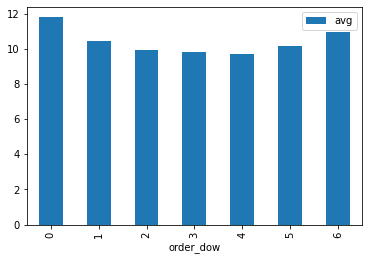

In [19]:
import matplotlib.pyplot as plt
r3.toPandas().plot.bar(x = 'order_dow', y = 'avg')

### 3.2 MBA pour le training set (15 points)

En utilisant les commandes du ``order_products__train.csv``, créez un bloc de données où chaque ligne contient la colonne ``transaction`` avec la liste des produits achetés, de manière similaire à le toy dataset. Ensuite, exécutez l'algorithme MBA pour cet ensemble de transactions.

- Vous devez signaler le temps passé pour effectuer cette tâche.
- La sortie doit contenir le nom des produits.

In [ ]:
%%time
"""
TODO: create a query to create and sctruct the transactions
"""
#df_order_prod = spark.read.csv('instacart/order_products__train.csv', header=True, sep=',', inferSchema=True)
df_order_prod = spark.read.csv('gs://inf81111-bucket-tp2-12781749821/instacart/order_products__train.csv', header=True, sep=',', inferSchema=True)
print('order_products__train.csv')
df_order_prod.show(5)

df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'

order_product_rdd = spark.sql('SELECT op.order_id, CONCAT_WS(";", COLLECT_LIST(p.product_name)) AS transaction'
            ' FROM order_prod op'
            ' JOIN products p ON op.product_id=p.product_id'
            ' GROUP BY op.order_id').rdd
print(order_product_rdd.take(5))

order_products__train.csv
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows



[Row(order_id=1139, transaction='Banana;Organic Strawberries;Red Vine Tomato;Organic Bakery Hamburger Buns Wheat - 8 CT;Guacamole;Picnic Potato Salad;Cinnamon Rolls with Icing;Flaky Biscuits;Buttermilk Biscuits'), Row(order_id=1143, transaction='Natural Premium Coconut Water;Calming Lavender Body Wash;Unscented Long Lasting Stick Deodorant;Organic Raspberries;Organic Blueberries;Organic Hass Avocado;Organic Butterhead (Boston, Butter, Bibb) Lettuce;Baby Arugula;Large Lemon;Organic Garlic;Organic Red Radish, Bunch;Rustic Baguette;Organic Brussel Sprouts;Organic Capellini Whole Wheat Pasta;Basil Pesto;Spring Water;Water'), Row(order_id=1342, transaction='Bag of Organic Bananas;Seedless Cucumbers;Organic Mandarins;Organic Strawberries;Versatile Stain Remover;Pink Lady Apples;Chicken Apple Sausage;Raw Shrimp'), Row(order_id=1468, transaction='Banana;Organic Ginger Root;Cage Free Grade AA Large White Eggs;Active Dry Yeast;Bartlett Pears;Natural Mini Pork Pepperoni;Organic Lacinato (Dinosaur

In [ ]:
%%time
"""
TODO: run the MBA algorithm and show the first 5 association rules
"""
op_patterns_rdd = order_product_rdd.flatMap(map_to_patterns)

op_combined_patterns_rdd = op_patterns_rdd.reduceByKey(reduce_patterns)

op_subpatterns_rdd = op_combined_patterns_rdd.flatMap(map_to_subpatterns)

op_combined_rules = op_subpatterns_rdd.aggregateByKey([], lambda x,y: x + [y] , lambda x,y: x + y)

op_assoc_rules = op_combined_rules.map(map_to_assoc_rules)

CPU times: user 10.8 ms, sys: 555 µs, total: 11.4 ms
Wall time: 28.2 ms


In [ ]:
%%time
# Output as dataframe
op_assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(5, truncate=100)

Exception in thread "serve RDD 211 with partitions 0" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


+---------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                       patterns|                                                                                   association_rules|
+---------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|('Febreze Fresh Clean Garbage Bags', 'Sparkling Mineral Water')|[('Organic Fuji Apple', 0.25), ('Smartwater Electrolyte Enhanced Water', 0.25), ('Complete Action...|
|('Garden Salsa Multigrain Chips', "Veggie Lover's Salad Blend")|[('The Tonight Dough™ Ice Cream', 0.25), ('Apple, Juicy Red, Family Pack', 0.25), ('Sun Dried Tom...|
|      ('Blueberries', 'Disinfecting Wipes Lemon & Fresh Scent')|[('Arnold Palmer Lite Half Iced Tea & Half Lemonade', 1.0), ('Original String Cheese', 1.0), ('Cr...

# 3.3 MBA pour le dataset complet (20 points)

Comme vous l'avez probablement remarqué, même pour un ensemble de données moins volumineux (le training dataset ne contient que 131 000 commandes), l'algorithme MBA est coûteux en calcul. Pour cette raison, cette fois, nous allons répéter le processus, mais en utilisant maintenant Google Cloud Platform (GCP) pour créer un grand cluster. Toutes les instructions pour créer un cluster avec spark et comment soumettre un travail seront expliquées dans le laboratoire. Dans tous les cas, vous devez lire les instructions données dans le ``Instruction_GCP.pdf``.

Cette fois, nous travaillerons avec le fichier ``order_products__prior.csv``, qui contient plus de 3M commandes.

**PRODUCTION ATTENDUE**

Après avoir exécuté le MBA pour la plus grande collection de commandes, sélectionnez au hasard UN produit acheté dans ``order_products__prior`` et affichez les règles d'association (nom du produit et valeur d'association) de ce produit, c'est-à-dire lorsque le produit est seul dans le panier. La sortie doit être formatée dans un tableau, où chaque ligne contenant les informations d'un produit associé. 

- Affichez l'ID et le nom du produit sélectionné au hasard.
- Signaler le temps d'exécution.

**Remarque importante : joignez des captures d'écran de votre sortie et de votre configuration de cluster.** 

In [ ]:
%%time
"""
TODO: create a query to create and sctruct the transactions from the order_products__prior.csv file
"""
#df_order_prod_prior = spark.read.csv('instacart/order_products__prior.csv', header=True, sep=',', inferSchema=True)
df_order_prod_prior = spark.read.csv('gs://inf81111-bucket-tp2-12781749821/instacart/order_products__prior.csv', header=True, sep=',', inferSchema=True)

df_order_prod_prior.createOrReplaceTempView("order_prod_prior") # creates table 'order_prod'

order_product_prior_rdd = spark.sql('SELECT op.order_id, CONCAT_WS(";", COLLECT_LIST(p.product_name)) AS transaction'
            ' FROM order_prod op'
            ' JOIN products p ON op.product_id=p.product_id'
            ' GROUP BY op.order_id').rdd

CPU times: user 6.15 ms, sys: 5.06 ms, total: 11.2 ms
Wall time: 3.36 s


In [ ]:
%%time
"""
TODO: run the MBA algorithm and print the requested output
"""
op_prior_patterns_rdd = order_product_prior_rdd.flatMap(map_to_patterns)

op_prior_combined_patterns_rdd = op_prior_patterns_rdd.reduceByKey(reduce_patterns)

op_prior_subpatterns_rdd = op_prior_combined_patterns_rdd.flatMap(map_to_subpatterns)

op_prior_combined_rules = op_prior_subpatterns_rdd.aggregateByKey([], lambda x,y: x + [y] , lambda x,y: x + y)

op_prior_assoc_rules = op_prior_combined_rules.map(map_to_assoc_rules)

CPU times: user 5.72 ms, sys: 4.87 ms, total: 10.6 ms
Wall time: 25.7 ms


In [ ]:
%%time
# Output as dataframe
op_prior_assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(5, truncate=100)

+-------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                 patterns|                                                                                   association_rules|
+-------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|               ('Organic Classic Original Hummus', 'Organic Red Cabbage')|[('Apple Cider Vinegar', 1.0), ('Plain Cultured Goat Milk Kefir', 1.0), ('Celery Sticks', 1.0), (...|
|                               ('1% Lowfat Milk', 'Organic Power Greens')|[('Lime Sparkling Water', 1.0), ('Mighty Mango Juice Smoothie', 1.0), ('Banana', 1.0), ('Protein ...|
|                                           ('Red Vine Tomato', 'Spinach')|[('Soft and Chewy Candy', 0.028571428571

In [ ]:
%%time
random_product = spark.sql('SELECT p.product_id, p.product_name'
            ' FROM order_prod op'
            ' JOIN products p ON op.product_id=p.product_id'
            ' ORDER BY RAND()'
            ' LIMIT 1').rdd.toDF(['product_id', 'product_name'])

print(random_product.show(1, truncate=False))

+----------+------------------+
|product_id|product_name      |
+----------+------------------+
|44170     |Tomato Basil Sauce|
+----------+------------------+

None
CPU times: user 6.71 ms, sys: 5.29 ms, total: 12 ms
Wall time: 1.29 s


In [ ]:
%%time
print(random_product.collect()[0][1])
print(op_prior_assoc_rules.lookup((random_product.collect()[0][1],)))

Tomato Basil Sauce


[[('Organic Chopped Spinach', 0.0125), ('Low Fat Vanilla Yogurt', 0.0125), ('Organics Spinach', 0.0125), ('Organic Celery', 0.0125), ('Organic YoKids Very Berry Smoothies', 0.0375), ('Organic Romaine', 0.025), ('Hickory Smoked Turkey Breast', 0.0125), ('Green Beans', 0.0125), ('Hand-Formed Vegan Burger Patties', 0.0125), ('Purity Farms Ghee Clarified Butter', 0.0125), ('Organic Lowfat Plain Unsweetened Kefir', 0.0125), ('Synergy Organic Kombucha Gingerberry', 0.0125), ('Organic Uncured Sliced Black Forest Ham', 0.0125), ('Sweet Potatoes', 0.0125), ('Baked White Cheddar Cheese Puffs', 0.0125), ('Organic Ketchup', 0.0125), ('Organic Tomato Basil Pasta Sauce', 0.0125), ('Organic Garbanzo Beans', 0.0125), ('Solid Albacore Tuna in Water', 0.0125), ('Organic Spinach And Cheese Ravioli', 0.0125), ('Red Raspberries', 0.0125), ('Sweet Potato Yam', 0.0125), ('Dark Chocolate Bar', 0.0125), ('Genovese Pesto With Truffles', 0.0125), ('Buffalo Style Chicken Wings', 0.0125), ('Organic Hothouse Cucumb

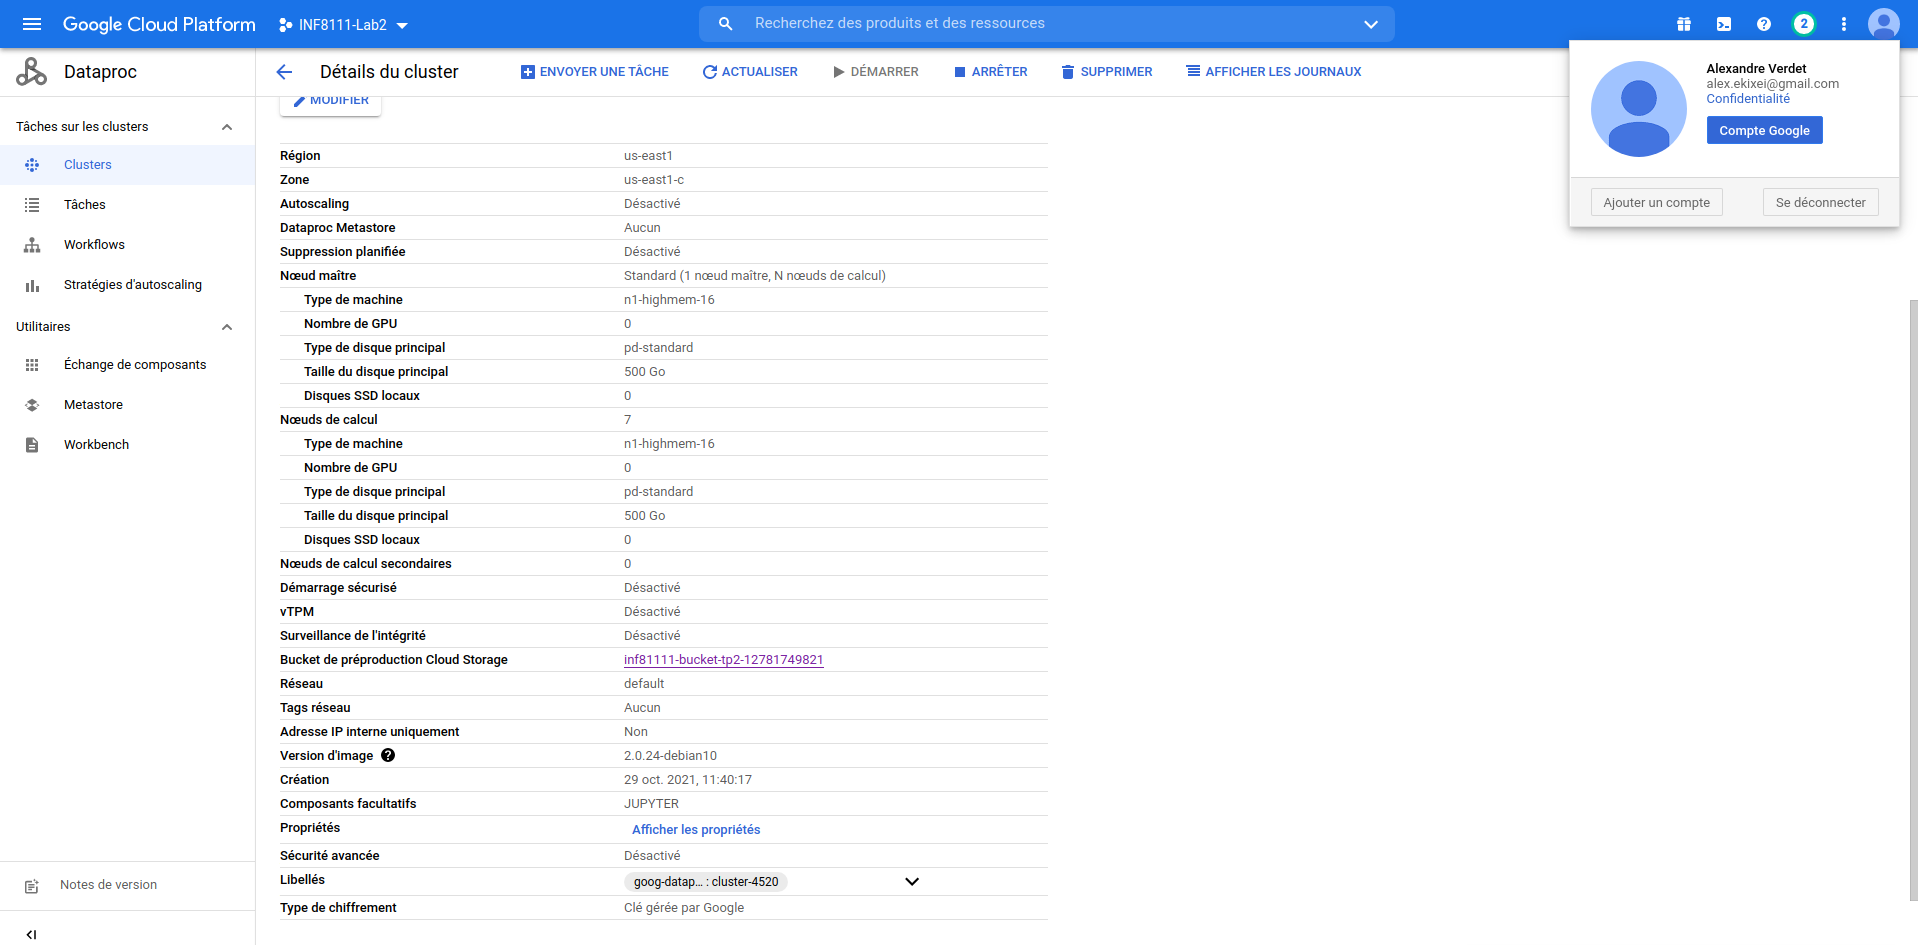